<a href="https://colab.research.google.com/github/anujpatel96/Assesment/blob/main/Interview_Preparation_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df1 = pd.read_excel("Fact_Sheet.xlsx")
df1

,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site
0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,gbc,blooth Cmpny,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002
1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,NaN,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001
2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002
3,INC072172,Ticket Manager,4,CLOSED,2020-10-05 11:24:29,2020-10-08 10:50:40,2020-10-14 16:04:25,Power Supply Fail,No Trouble Found,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,Physical Server,GBC-DC-001
4,INC072173,Ticket Manager,5,CANCELLED,2020-10-05 11:24:29,2020-10-08 10:55:40,2020-10-10 14:14:05,Cold Start,Ticket Cancelled,NaN,Pie Piper Inc,CRCTPPI-0001CKT-AAA,Virtual Server,PPI-DC-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,INC072292,Ticket Manager,5,RESOLVED,2021-01-28 05:12:48,2021-01-29 11:38:24,NaT,Power Supply Fail,Power Supply Back,C9S,cloud Nine superstore,CRCTC9S-0001CKT-AAA,Data Center,C9S-DC-001
151,INC072293,Ticket Manager,3,INPROGRESS,2021-01-04 13:11:47,NaT,NaT,Circuit State Change,NaN,BC,Bluth Company,CRCTBBC-0001CKT-AAA,VOIP,GBC-CO-001
152,INC072294,Ticket Manager,1,INPROGRESS,2021-01-04 13:19:53,NaT,NaT,Switch Down,NaN,rbm,rosebud motel,CRCTRBM-0001CKT-AAA,PSTN,RBM-SC-001
153,INC072295,Ticket Manager,2,INPROGRESS,2021-01-04 13:53:10,NaT,NaT,Interface Down,NaN,PPI,Pie Piper Inc,CRCTPPI-0001CKT-AAA,Fiber Internet,PPI-SVC-001


In [3]:
df2 = pd.read_excel("Customer_Sheet.xlsx")
df2.head(10)

,inc_cust_id,inc_cust_name,inc_circuit,inc_site
0,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,GBC-BS-001
1,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,GBC-CO-001
2,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,GBC-DC-001
3,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,GBC-MH-001
4,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,GBC-MH-002
5,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,C9S-DC-001
6,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,C9S-STR-001
7,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,C9S-STR-002
8,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,DMP-CO-001
9,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,DMP-CO-002


In [4]:
df3 = pd.read_excel("Severity_Target_Sheet.xlsx")
df3.head(10)

,Severity,Target Time To Resolve
0,1,2
1,2,4
2,3,8
3,4,24
4,5,48


In [5]:
df1[["inc_cust_id"]].describe()

,inc_cust_id
count,131
unique,22
top,GBC
freq,13


In [6]:
df1[["inc_cust_name"]].describe()

,inc_cust_name
count,149
unique,28
top,Bluth Company
freq,15


In [7]:
df1[["inc_site"]].describe()

,inc_site
count,155
unique,26
top,PPI-SVC-001
freq,14


In [8]:
for i in range(len(df1)):
  df1["inc_cust_id"][i] = df1["inc_site"][i][:3]
print(df1[["inc_cust_id"]]["inc_cust_id"].unique())
print()

for i in range(len(df1)):
  if df1["inc_cust_id"][i] == "IBC":
    df1["inc_cust_id"][i] = "IBB"
  if df1["inc_site"][i][:3] == "IBC":
    df1["inc_site"][i] = "IBB" + df1["inc_site"][i][3:]
print(df1[["inc_cust_id"]]["inc_cust_id"].unique())
print()
df1[["inc_site"]].describe()

['GBC' 'IBB' 'TAR' 'PPI' 'C9S' 'DMP' 'RBM' 'IBC']

['GBC' 'IBB' 'TAR' 'PPI' 'C9S' 'DMP' 'RBM']



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,inc_site
count,155
unique,25
top,PPI-SVC-001
freq,14


In [9]:
dict = {}
for i in range(len(df2)):
  if df2["inc_cust_id"][i] not in dict:
    dict[df2["inc_cust_id"][i]] = df2["inc_cust_name"][i]
dict

{'C9S': 'Cloud 9 Superstore',
 'DMP': 'Dunder Mifflin Paper Company, Inc.',
 'GBC': 'Bluth Company',
 'IBB': 'Iron Bank',
 'PPI': 'Pied Piper Inc',
 'RBM': 'Rose Bud Motel',
 'TAR': 'The Alibi Room'}

In [10]:
for i in range(len(df1)):
  if df1["inc_cust_id"][i] in dict:
    df1["inc_cust_name"][i] = dict[df1["inc_cust_id"][i]]
df1[["inc_cust_name"]].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,inc_cust_name
count,155
unique,7
top,"Dunder Mifflin Paper Company, Inc."
freq,30


In [11]:
df1

,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site
0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002
1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001
2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002
3,INC072172,Ticket Manager,4,CLOSED,2020-10-05 11:24:29,2020-10-08 10:50:40,2020-10-14 16:04:25,Power Supply Fail,No Trouble Found,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,Physical Server,GBC-DC-001
4,INC072173,Ticket Manager,5,CANCELLED,2020-10-05 11:24:29,2020-10-08 10:55:40,2020-10-10 14:14:05,Cold Start,Ticket Cancelled,PPI,Pied Piper Inc,CRCTPPI-0001CKT-AAA,Virtual Server,PPI-DC-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,INC072292,Ticket Manager,5,RESOLVED,2021-01-28 05:12:48,2021-01-29 11:38:24,NaT,Power Supply Fail,Power Supply Back,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,Data Center,C9S-DC-001
151,INC072293,Ticket Manager,3,INPROGRESS,2021-01-04 13:11:47,NaT,NaT,Circuit State Change,NaN,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,VOIP,GBC-CO-001
152,INC072294,Ticket Manager,1,INPROGRESS,2021-01-04 13:19:53,NaT,NaT,Switch Down,NaN,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,PSTN,RBM-SC-001
153,INC072295,Ticket Manager,2,INPROGRESS,2021-01-04 13:53:10,NaT,NaT,Interface Down,NaN,PPI,Pied Piper Inc,CRCTPPI-0001CKT-AAA,Fiber Internet,PPI-SVC-001


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


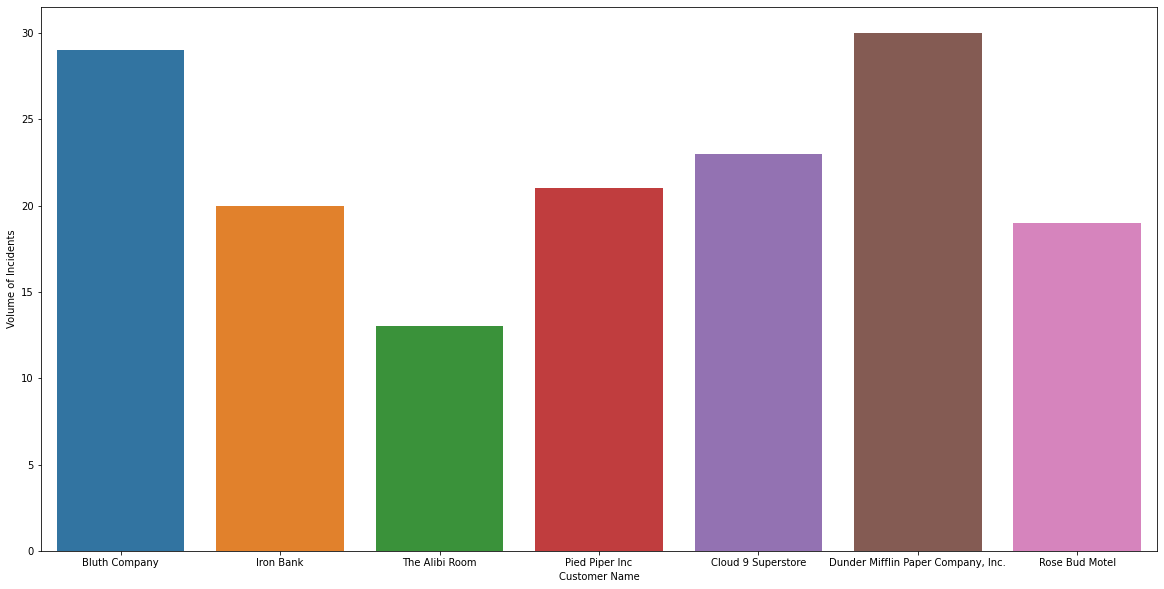

In [12]:
plt.figure(figsize=(20,10))
sns.countplot(df1["inc_cust_name"])
plt.ylabel("Volume of Incidents")
plt.xlabel("Customer Name")
plt.show()

In [13]:
df1["Month"] = "Nan"
for i in range(len(df1)):
  df1["Month"][i]= df1["inc_creation_dt"][i].month


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


             GBC  IBB  DMP  PPI  C9S  RBM  TAR
October-20     5    5    4    3    3    2    2
November-20    8    6    9    4    8    7    4
December-20    8    7    9   10    6    3    4
January-20     8    2    8    4    6    7    3

             DMP-CO-004  DMP-CO-003  ...  RBM-SC-004  DMP-DC-002
October-20          2.0         2.0  ...         NaN         NaN
November-20         NaN         1.0  ...         1.0         NaN
December-20         3.0         3.0  ...         NaN         NaN
January-20          NaN         NaN  ...         1.0         1.0

[4 rows x 25 columns]

             Power Supply Fail  Circuit Down  ...  Server Down  Router Down
October-20                 3.0           3.0  ...          1.0          NaN
November-20                8.0           4.0  ...          3.0          2.0
December-20                8.0           5.0  ...          2.0          NaN
January-20                 9.0           1.0  ...          2.0          2.0

[4 rows x 12 columns]

           

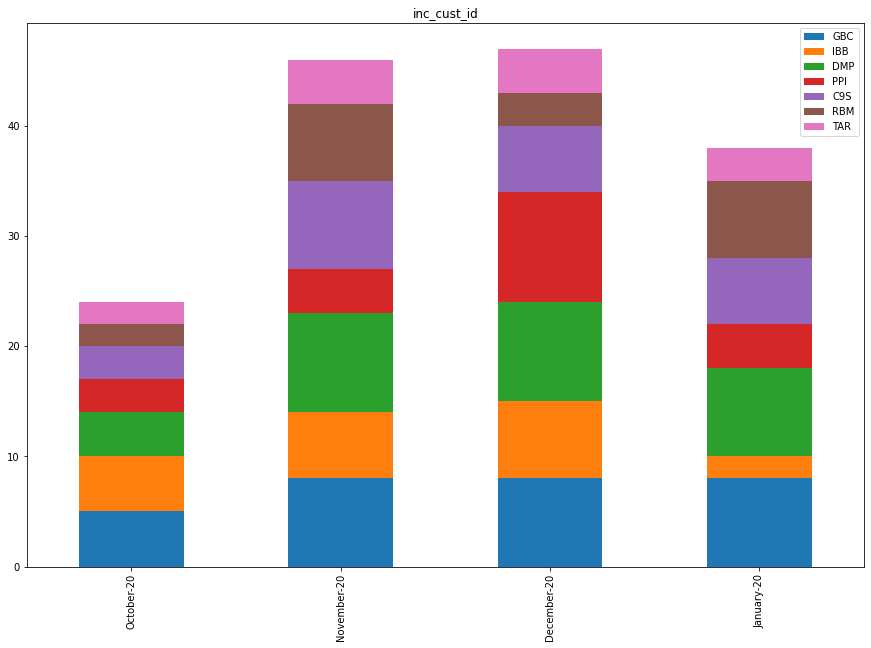

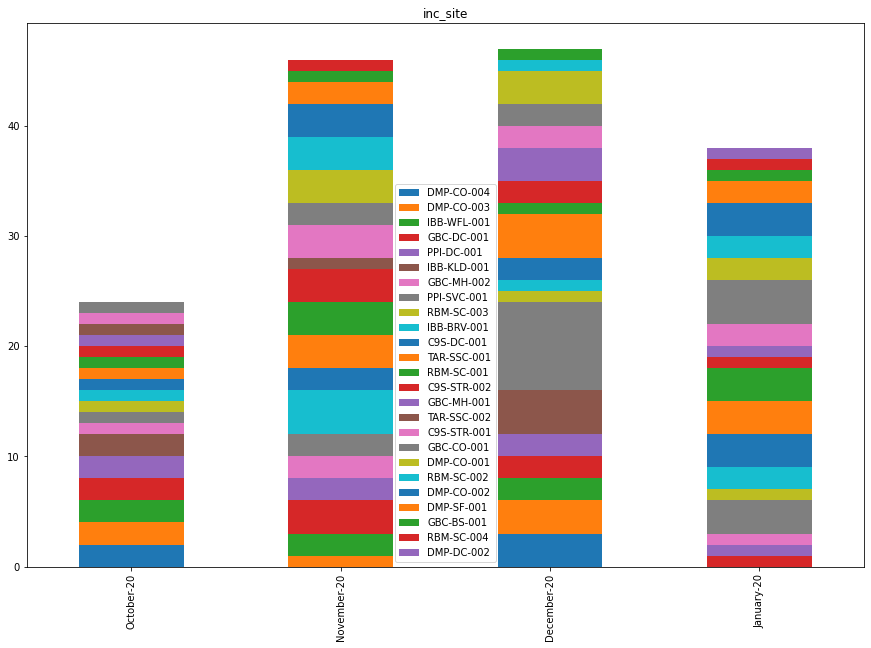

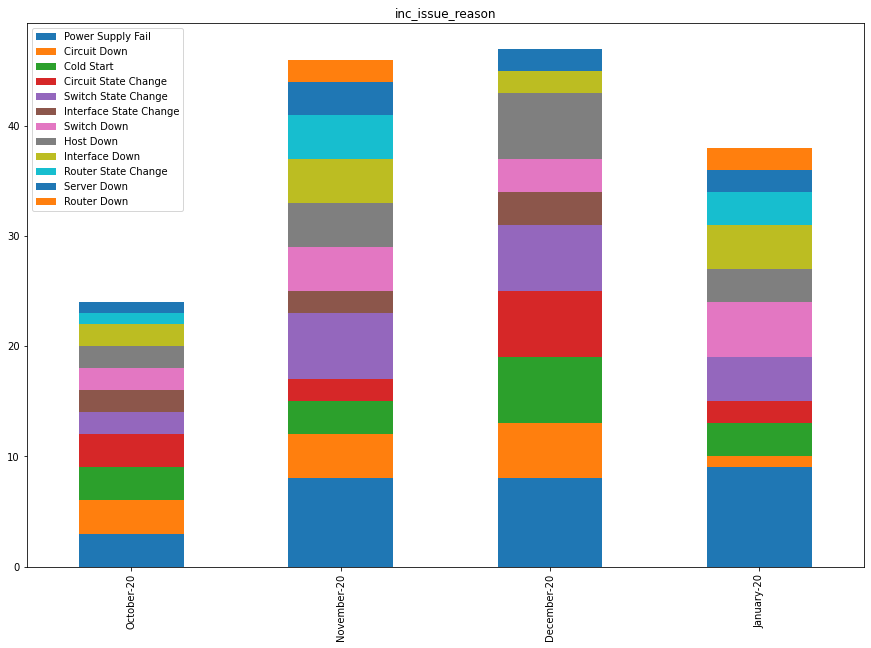

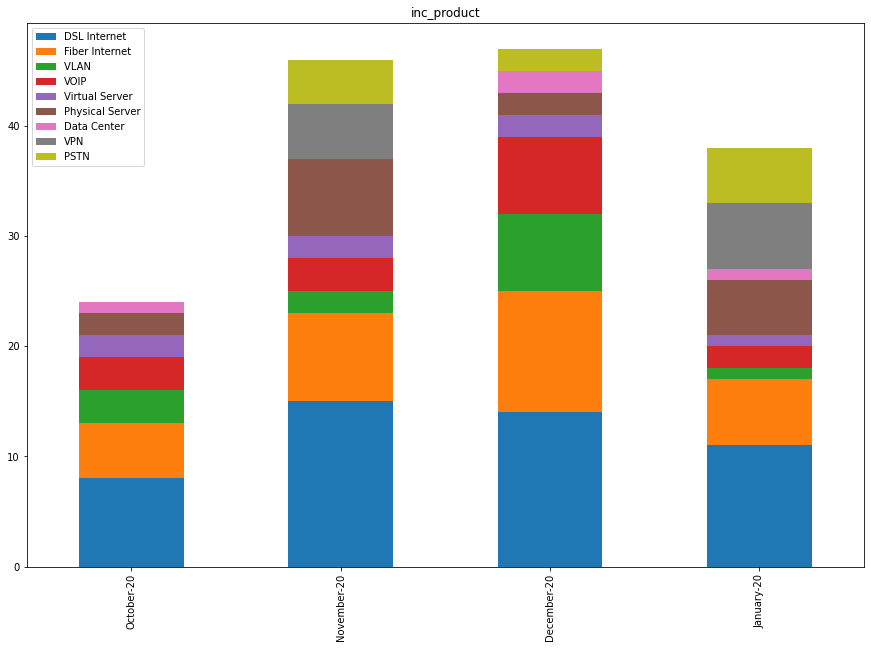

In [14]:
def bar_chart(feature):
  Oct_20 = df1[df1['Month']==10][feature].value_counts()
  Nov_20 = df1[df1['Month']==11][feature].value_counts()
  Dec_20 = df1[df1['Month']==12][feature].value_counts()
  Jan_21 = df1[df1['Month']==1][feature].value_counts()

  temp_df = pd.DataFrame([Oct_20,Nov_20,Dec_20,Jan_21])
  temp_df.index = ['October-20','November-20', 'December-20','January-20']
  temp_df.plot(kind='bar',stacked=True, figsize=(15,10))
  plt.title(feature)
  print(temp_df)

for i in df1[['inc_cust_id','inc_site', 'inc_issue_reason', 'inc_product']]:
    bar_chart(i)
    print()


In [15]:
df1.dropna(subset = ["inc_resolution_dt"], inplace=True)
df1

,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site,Month
0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002,10
1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001,10
2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002,10
3,INC072172,Ticket Manager,4,CLOSED,2020-10-05 11:24:29,2020-10-08 10:50:40,2020-10-14 16:04:25,Power Supply Fail,No Trouble Found,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,Physical Server,GBC-DC-001,10
4,INC072173,Ticket Manager,5,CANCELLED,2020-10-05 11:24:29,2020-10-08 10:55:40,2020-10-10 14:14:05,Cold Start,Ticket Cancelled,PPI,Pied Piper Inc,CRCTPPI-0001CKT-AAA,Virtual Server,PPI-DC-001,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,INC072290,Ticket Manager,5,RESOLVED,2021-01-26 01:21:08,2021-01-27 03:09:33,NaT,Cold Start,Dropped & Recovered,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,VPN,GBC-CO-001,1
147,INC072192,Alarm Response,3,RESOLVED,2021-01-26 04:30:59,2021-01-26 06:12:03,NaT,Switch State Change,Dropped & Recovered,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,DSL Internet,RBM-SC-003,1
148,INC072193,Alarm Response,4,RESOLVED,2021-01-27 01:58:40,2021-01-27 02:29:41,NaT,Power Supply Fail,Power Supply Back,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,VPN,DMP-CO-002,1
149,INC072291,Ticket Manager,2,RESOLVED,2021-01-27 08:55:54,2021-01-27 10:13:07,NaT,Interface Down,NaN,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,PSTN,TAR-SSC-001,1


In [16]:
df1["Resolution Time[in hours]"] = "Nan"
for i in range(len(df1)):
  difference = df1["inc_resolution_dt"][i] - df1["inc_creation_dt"][i]
  temp = (difference.seconds + int(str(difference)[0]) * 86400) / 3600
  df1["Resolution Time[in hours]"][i] = float("{:.2f}".format(temp))
df1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site,Month,Resolution Time[in hours]
0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002,10,5.07
1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001,10,3.01
2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002,10,50.91
3,INC072172,Ticket Manager,4,CLOSED,2020-10-05 11:24:29,2020-10-08 10:50:40,2020-10-14 16:04:25,Power Supply Fail,No Trouble Found,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,Physical Server,GBC-DC-001,10,71.44
4,INC072173,Ticket Manager,5,CANCELLED,2020-10-05 11:24:29,2020-10-08 10:55:40,2020-10-10 14:14:05,Cold Start,Ticket Cancelled,PPI,Pied Piper Inc,CRCTPPI-0001CKT-AAA,Virtual Server,PPI-DC-001,10,71.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,INC072290,Ticket Manager,5,RESOLVED,2021-01-26 01:21:08,2021-01-27 03:09:33,NaT,Cold Start,Dropped & Recovered,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,VPN,GBC-CO-001,1,25.81
147,INC072192,Alarm Response,3,RESOLVED,2021-01-26 04:30:59,2021-01-26 06:12:03,NaT,Switch State Change,Dropped & Recovered,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,DSL Internet,RBM-SC-003,1,1.68
148,INC072193,Alarm Response,4,RESOLVED,2021-01-27 01:58:40,2021-01-27 02:29:41,NaT,Power Supply Fail,Power Supply Back,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,VPN,DMP-CO-002,1,0.52
149,INC072291,Ticket Manager,2,RESOLVED,2021-01-27 08:55:54,2021-01-27 10:13:07,NaT,Interface Down,NaN,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,PSTN,TAR-SSC-001,1,1.29


inc_cust_id
               GBC    IBB    TAR    PPI    C9S    DMP    RBM
October-20   18.45   2.21  56.98  41.13   6.42   7.75  14.19
November-20  25.50  19.71  21.58  23.84  29.71  38.70   9.17
December-20   8.97  33.74  13.87  33.04   6.76  21.48  43.24
January-21    5.02  14.74   1.49   8.73   5.53   6.68   2.76
inc_site
             GBC-MH-002  IBB-BRV-001  ...  GBC-BS-001  DMP-SF-001
October-20         5.07         3.01  ...         NaN         NaN
November-20        5.78        29.15  ...        2.03        3.41
December-20         NaN         9.98  ...        0.28         NaN
January-21         3.23        14.74  ...        0.15        1.48

[4 rows x 24 columns]
inc_issue_reason
             Interface Down  Switch State Change  ...  Server Down  Router Down
October-20             3.35                 3.04  ...         1.13          NaN
November-20            6.04                13.88  ...        13.00        25.18
December-20            9.11                22.53  ...         2.

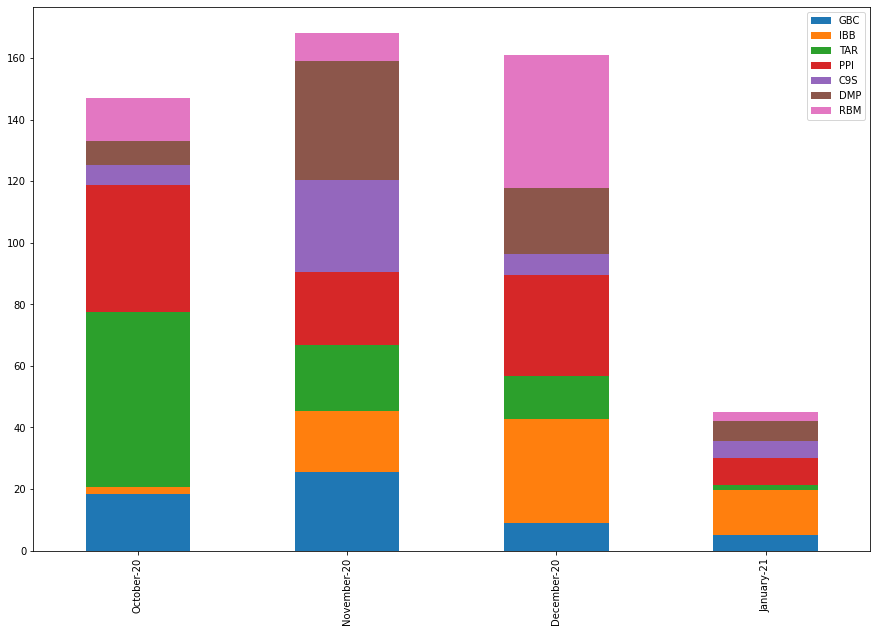

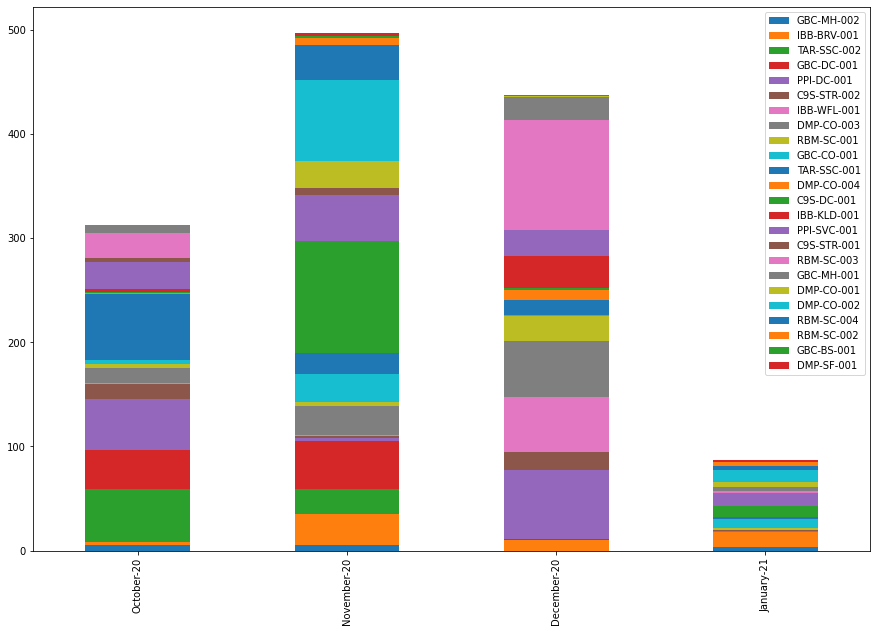

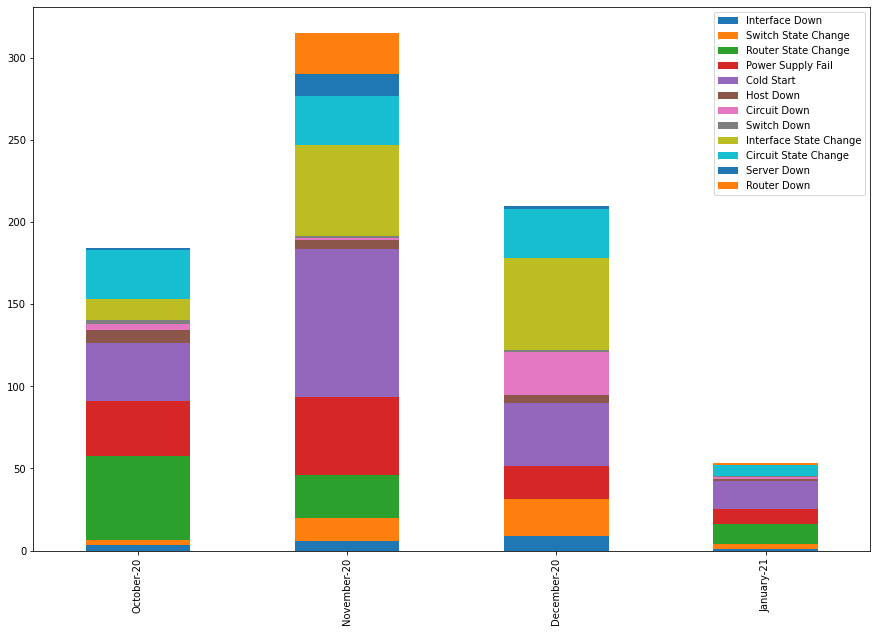

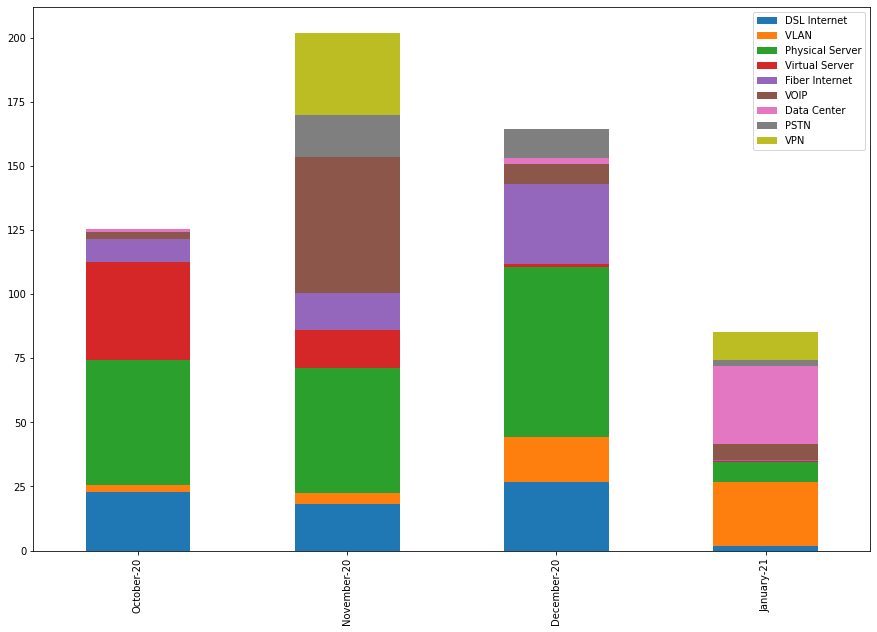

In [17]:
def bar_chart(feature):
  values = df1[feature].unique()
  arr = {}
  for i in values:
    for j in df1["Month"].unique():
      x = df1[df1['Month']== j]
      b = x[x[feature] == i]
      mean_val = float("{:.2f}".format(b['Resolution Time[in hours]'].mean()))
      if i not in arr:
        arr[i] = [mean_val]
      else:
        arr[i].append(mean_val)
  df5 = pd.DataFrame(data=arr) 
  df5.index = ['October-20','November-20', 'December-20','January-21']
  df5.plot(kind='bar',stacked=True, figsize=(15,10))
  print(f"{feature}")
  print(df5)
  print("=============================================================================")

for i in df1[['inc_cust_id','inc_site', 'inc_issue_reason', 'inc_product']]:
  
    bar_chart(i)


In [32]:
df1["Resolution_in_target_time"] = "Nan"
for i in range(len(df1)):
  for (j,k) in zip(range(len(df3["Severity"])), range(len(df3["Target Time To Resolve"]))):
    if df1["inc_severity"][i] == df3["Severity"][j]:
      
      if df1["Resolution Time[in hours]"][i] > df3["Target Time To Resolve"][k]:
        df1["Resolution_in_target_time"][i] = False
       
      else:
        df1["Resolution_in_target_time"][i] = True  
df1



  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site,Month,Resolution Time[in hours],Resolution_in_target_time
0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002,10,5.07,False
1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001,10,3.01,True
2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002,10,50.91,False
3,INC072172,Ticket Manager,4,CLOSED,2020-10-05 11:24:29,2020-10-08 10:50:40,2020-10-14 16:04:25,Power Supply Fail,No Trouble Found,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,Physical Server,GBC-DC-001,10,71.44,False
4,INC072173,Ticket Manager,5,CANCELLED,2020-10-05 11:24:29,2020-10-08 10:55:40,2020-10-10 14:14:05,Cold Start,Ticket Cancelled,PPI,Pied Piper Inc,CRCTPPI-0001CKT-AAA,Virtual Server,PPI-DC-001,10,71.52,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,INC072290,Ticket Manager,5,RESOLVED,2021-01-26 01:21:08,2021-01-27 03:09:33,NaT,Cold Start,Dropped & Recovered,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,VPN,GBC-CO-001,1,25.81,True
147,INC072192,Alarm Response,3,RESOLVED,2021-01-26 04:30:59,2021-01-26 06:12:03,NaT,Switch State Change,Dropped & Recovered,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,DSL Internet,RBM-SC-003,1,1.68,True
148,INC072193,Alarm Response,4,RESOLVED,2021-01-27 01:58:40,2021-01-27 02:29:41,NaT,Power Supply Fail,Power Supply Back,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,VPN,DMP-CO-002,1,0.52,True
149,INC072291,Ticket Manager,2,RESOLVED,2021-01-27 08:55:54,2021-01-27 10:13:07,NaT,Interface Down,NaN,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,PSTN,TAR-SSC-001,1,1.29,True


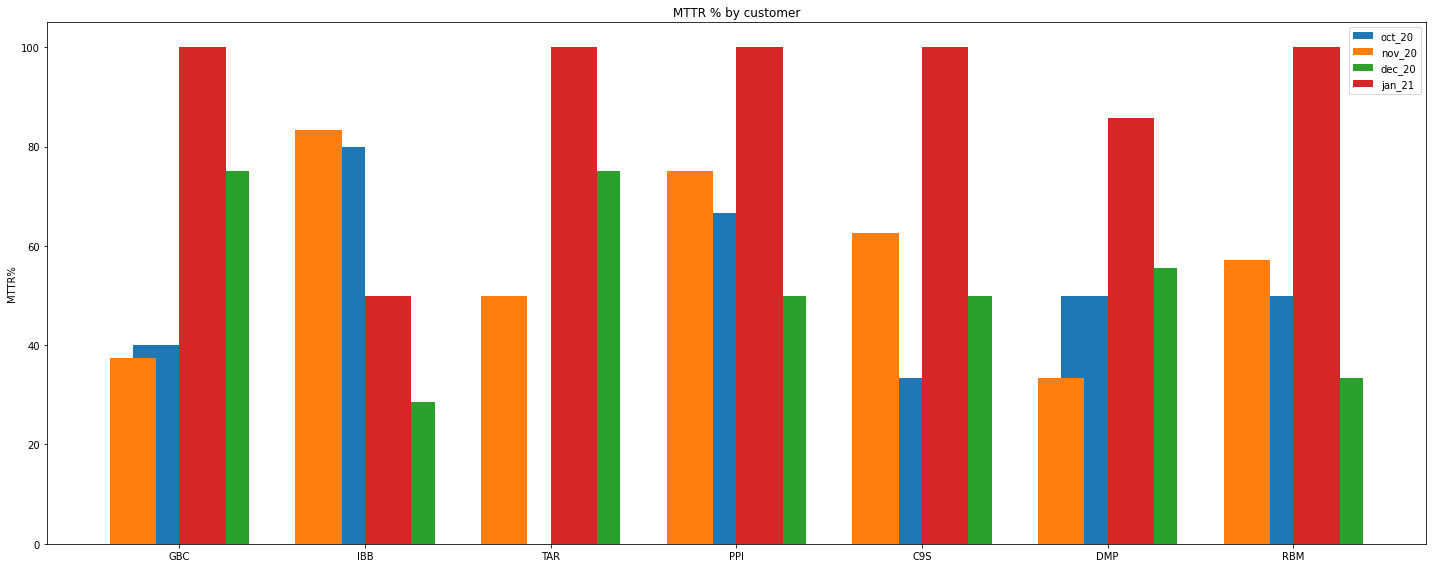

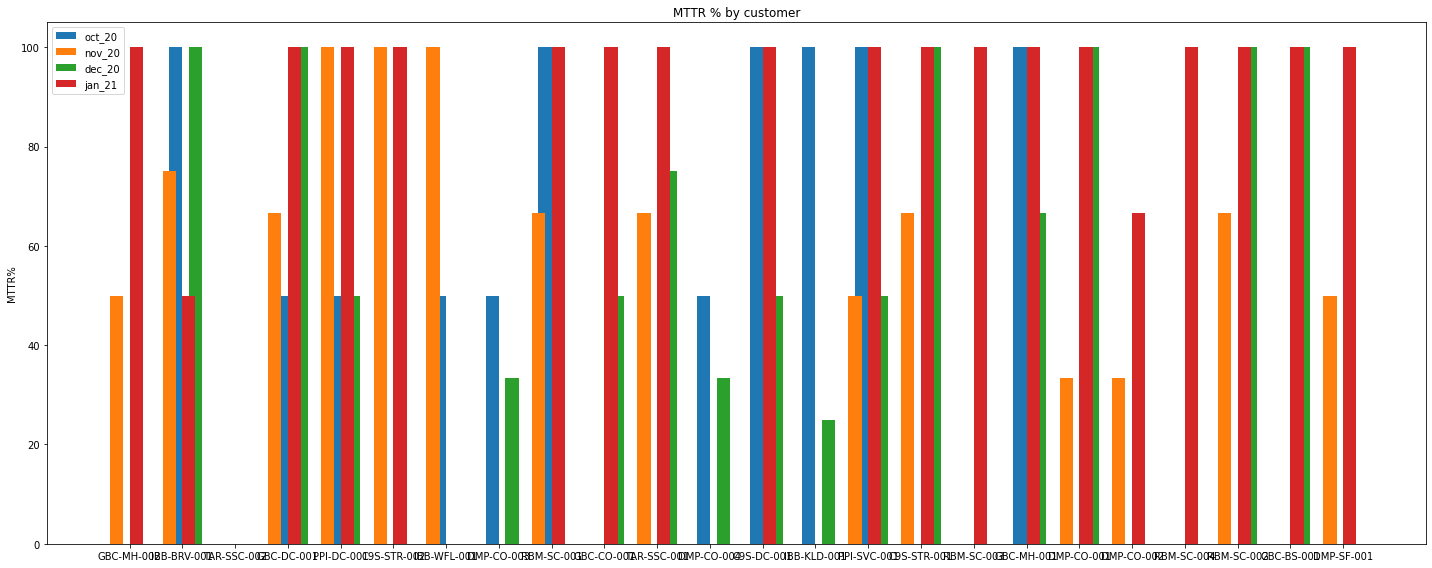

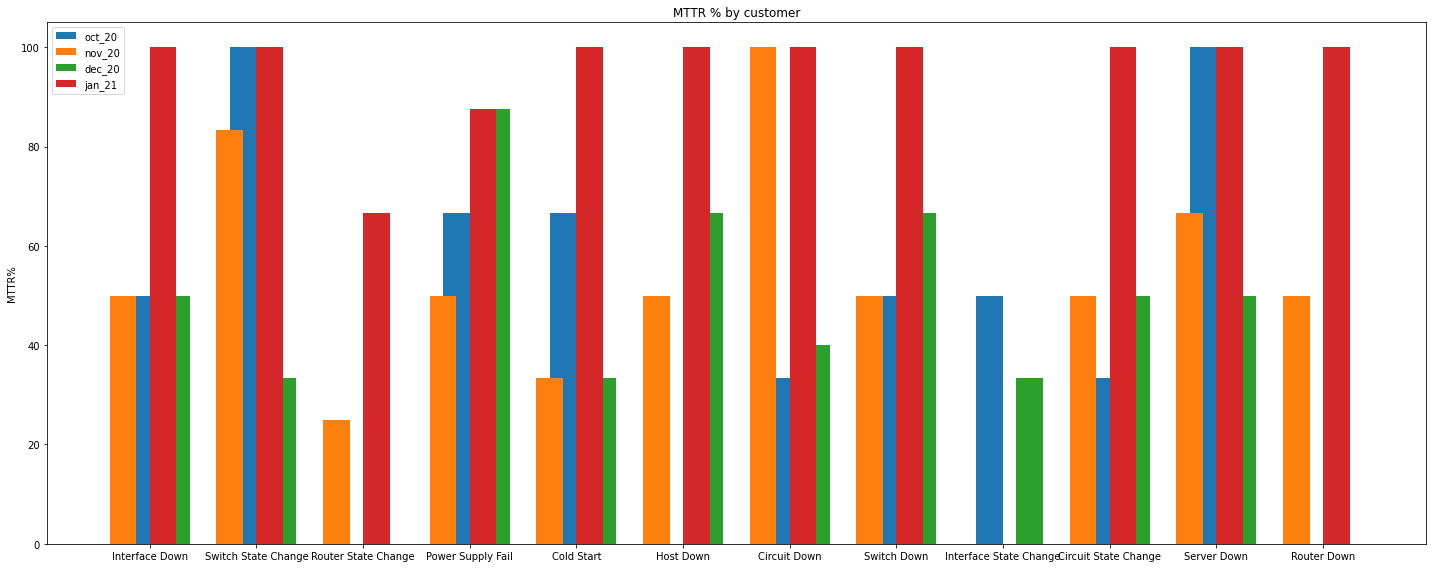

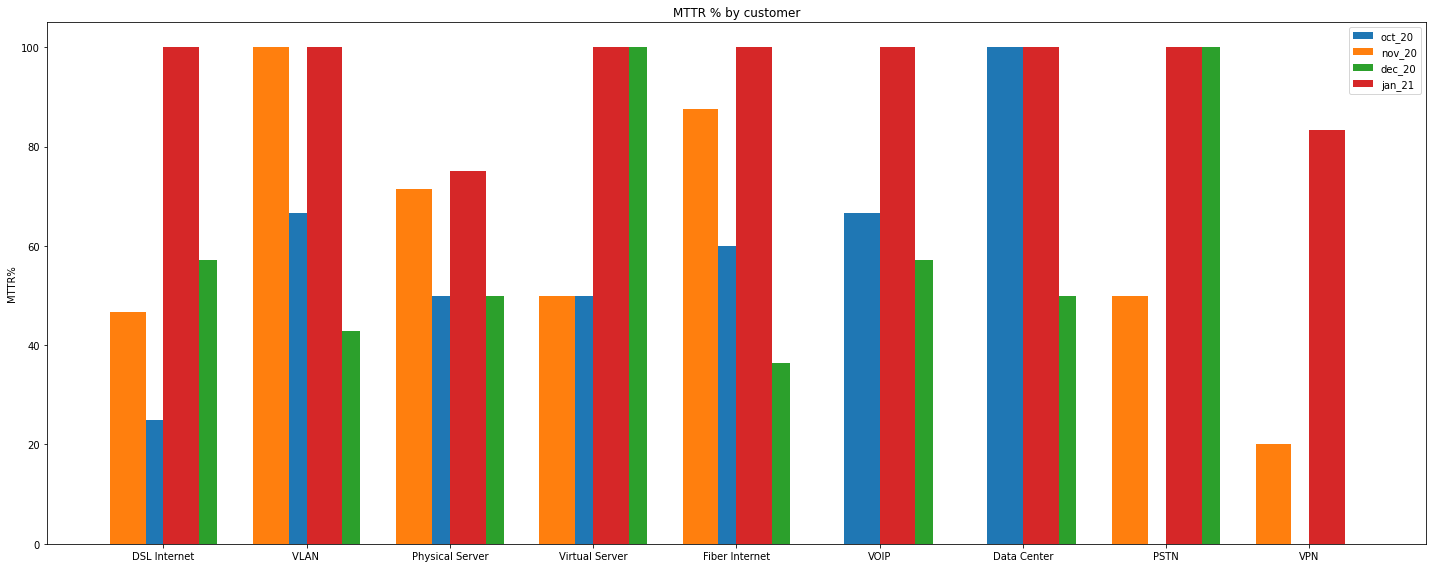

In [119]:
def bar_chart(feature):
  oct_20 = []
  nov_20 = []
  dec_20 = []
  jan_21 = []
  labels = df1[feature].unique()
  for i in labels:
    for j in df1["Month"].unique():
      x = df1[df1['Month']== j]
      b = x[x[feature] == i]
      try:
        mttr = b["Resolution_in_target_time"].value_counts()[True] / b["Resolution_in_target_time"].count() * 100
      except:
        mttr = 0 
      if j == 10:
        oct_20.append(mttr)
      elif j == 11:
        nov_20.append(mttr)
      elif j == 12:
        dec_20.append(mttr)
      elif j == 1:
        jan_21.append(mttr)
  x = np.arange(len(labels)) 
  width = 0.25

  fig, ax = plt.subplots(figsize=(20,8))
  rects1 = ax.bar(x - width/2 , oct_20, width, label='oct_20')
  rects2 = ax.bar(x - width, nov_20, width, label='nov_20')
  rects3 = ax.bar(x + width, dec_20, width, label='dec_20')
  rects4 = ax.bar(x + width/2, jan_21, width, label='jan_21')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('MTTR%')
  ax.set_title('MTTR % by customer')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  fig.tight_layout()
  plt.show()

for i in df1[['inc_cust_id','inc_site', 'inc_issue_reason', 'inc_product']]:
    bar_chart(i)


In [144]:
df1["Year"] = "Nan"
for i in range(len(df1)):
  df1["Year"][i] = df1["inc_creation_dt"][i].year
df1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site,Month,Resolution Time[in hours],Resolution_in_target_time,Year
0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002,10,5.07,False,2020
1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001,10,3.01,True,2020
2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002,10,50.91,False,2020
3,INC072172,Ticket Manager,4,CLOSED,2020-10-05 11:24:29,2020-10-08 10:50:40,2020-10-14 16:04:25,Power Supply Fail,No Trouble Found,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,Physical Server,GBC-DC-001,10,71.44,False,2020
4,INC072173,Ticket Manager,5,CANCELLED,2020-10-05 11:24:29,2020-10-08 10:55:40,2020-10-10 14:14:05,Cold Start,Ticket Cancelled,PPI,Pied Piper Inc,CRCTPPI-0001CKT-AAA,Virtual Server,PPI-DC-001,10,71.52,False,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,INC072290,Ticket Manager,5,RESOLVED,2021-01-26 01:21:08,2021-01-27 03:09:33,NaT,Cold Start,Dropped & Recovered,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,VPN,GBC-CO-001,1,25.81,True,2021
147,INC072192,Alarm Response,3,RESOLVED,2021-01-26 04:30:59,2021-01-26 06:12:03,NaT,Switch State Change,Dropped & Recovered,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,DSL Internet,RBM-SC-003,1,1.68,True,2021
148,INC072193,Alarm Response,4,RESOLVED,2021-01-27 01:58:40,2021-01-27 02:29:41,NaT,Power Supply Fail,Power Supply Back,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,VPN,DMP-CO-002,1,0.52,True,2021
149,INC072291,Ticket Manager,2,RESOLVED,2021-01-27 08:55:54,2021-01-27 10:13:07,NaT,Interface Down,NaN,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,PSTN,TAR-SSC-001,1,1.29,True,2021


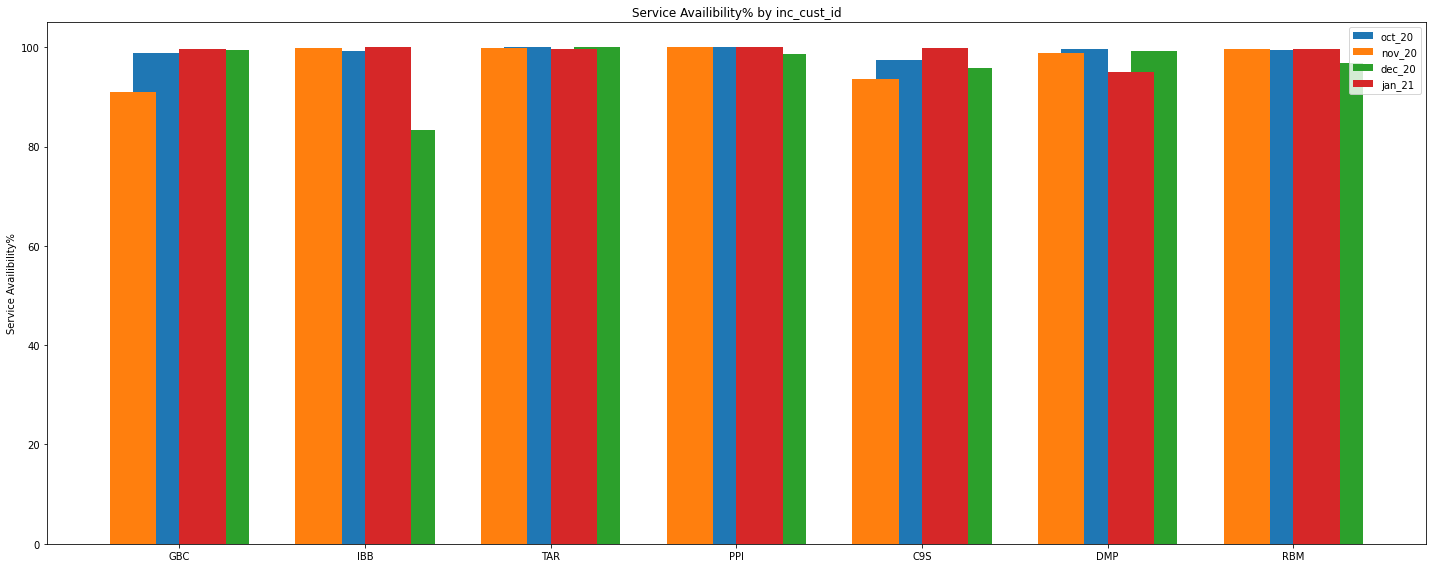

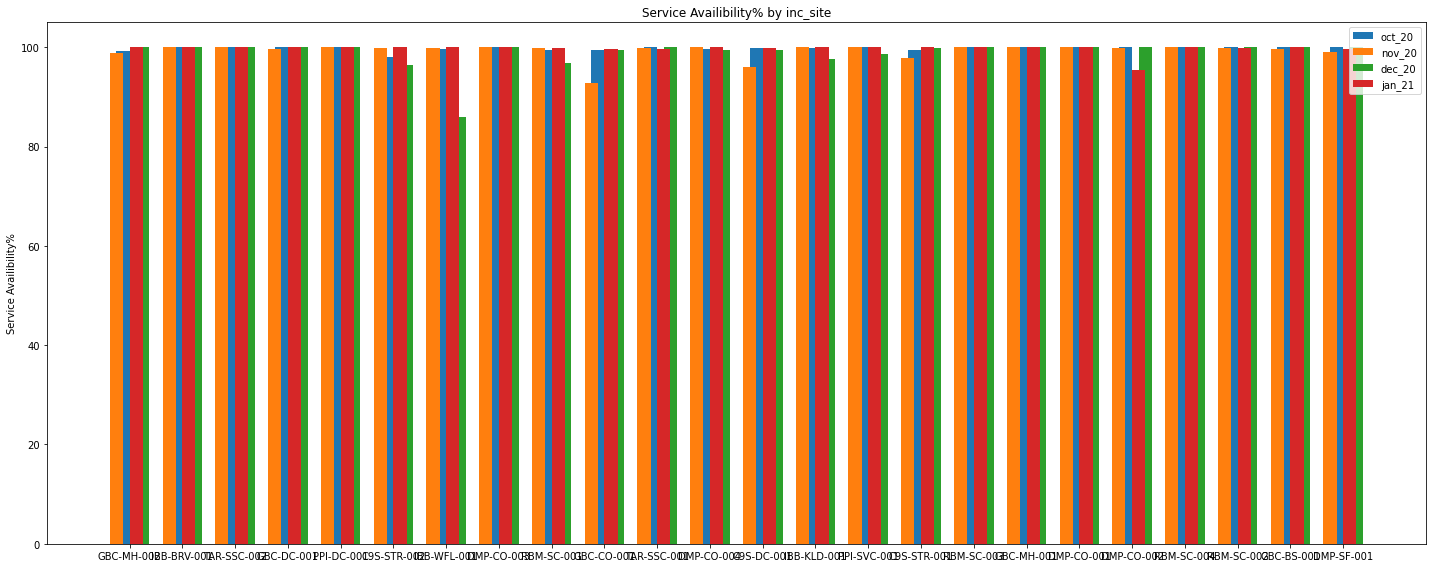

In [173]:
def bar_chart(feature):
  oct_20 = []
  nov_20 = []
  dec_20 = []
  jan_21 = []
  month_year = {10:31, 11:30, 12:31, 1:31}
  labels = df1[feature].unique()
  for i in labels:
    for j in df1["Month"].unique():
      x = df1[df1['Month']== j]
      b = x[x[feature] == i]
      c  = b.loc[b['inc_severity'].isin([1,2])]
      down_time = c["Resolution Time[in hours]"].sum()
      uptime = (month_year[j] * 24) - down_time
      service_avail = (uptime / (month_year[j] *24)) * 100
      if j == 10:
          oct_20.append(service_avail)
          service_avail = 0
          
      elif j == 11:
        nov_20.append(service_avail)
        service_avail = 0
      
      elif j == 12:
        dec_20.append(service_avail)
        service_avail = 0
    
      elif j == 1:
        jan_21.append(service_avail)
        service_avail = 0

  x = np.arange(len(labels)) 
  width = 0.25

  fig, ax = plt.subplots(figsize=(20,8))
  rects1 = ax.bar(x - width/2 , oct_20, width, label='oct_20')
  rects2 = ax.bar(x - width, nov_20, width, label='nov_20')
  rects3 = ax.bar(x + width, dec_20, width, label='dec_20')
  rects4 = ax.bar(x + width/2, jan_21, width, label='jan_21')


  ax.set_ylabel('Service Availibility%')
  ax.set_title(f'Service Availibility% by {feature}')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  fig.tight_layout()
  plt.show()

for i in df1[['inc_cust_id','inc_site']]:
    bar_chart(i)
    


In [174]:
df1.head(10)

,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site,Month,Resolution Time[in hours],Resolution_in_target_time,Year
0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002,10,5.07,False,2020
1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001,10,3.01,True,2020
2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002,10,50.91,False,2020
3,INC072172,Ticket Manager,4,CLOSED,2020-10-05 11:24:29,2020-10-08 10:50:40,2020-10-14 16:04:25,Power Supply Fail,No Trouble Found,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,Physical Server,GBC-DC-001,10,71.44,False,2020
4,INC072173,Ticket Manager,5,CANCELLED,2020-10-05 11:24:29,2020-10-08 10:55:40,2020-10-10 14:14:05,Cold Start,Ticket Cancelled,PPI,Pied Piper Inc,CRCTPPI-0001CKT-AAA,Virtual Server,PPI-DC-001,10,71.52,False,2020
5,INC072174,Ticket Manager,1,CLOSED,2020-10-06 19:53:00,2020-10-07 09:58:04,2020-10-07 11:33:51,Host Down,Host Config Change,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,Fiber Internet,C9S-STR-002,10,14.08,False,2020
6,INC072175,Ticket Manager,1,CLOSED,2020-10-06 20:10:25,2020-10-06 22:21:16,2020-10-06 22:22:04,Circuit Down,Circuit Config Change,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,Fiber Internet,IBB-WFL-001,10,2.18,False,2020
7,INC072176,Ticket Manager,1,CLOSED,2020-10-06 21:00:01,2020-10-06 22:10:06,2020-10-06 22:21:04,Switch Down,Switch Incident Closed,IBB,Iron Bank,CRCTIBB-0001CKT-AAB,Fiber Internet,IBB-WFL-001,10,1.17,True,2020
8,INC072177,Ticket Manager,4,CLOSED,2020-10-08 08:26:09,2020-10-09 09:35:20,2020-10-09 09:38:29,Interface State Change,No Trouble Found,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,DSL Internet,DMP-CO-003,10,25.15,False,2020
9,INC072178,Ticket Manager,2,CLOSED,2020-10-08 08:32:59,2020-10-08 12:20:38,2020-10-08 12:22:38,Circuit Down,Circuit Config Change,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,DSL Internet,RBM-SC-001,10,3.79,True,2020
